<a href="https://colab.research.google.com/github/matteolimoncini/COVID-19-search-engine/blob/main/COVID_19_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# various import and install
%%capture
!pip install split-folders
!pip install clustimage


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
import IPython.display as display
import shutil
import time
import datetime

import seaborn as sns
from sklearn.metrics import confusion_matrix

from PIL import Image
from scipy.spatial import distance

from clustimage import Clustimage

from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Sarscov2 ctscan dataset

In [ ]:
# setting up kaggle and download dataset

%%capture
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip sarscov2-ctscan-dataset.zip -d sarscov2-ctscan-dataset
!rm sarscov2-ctscan-dataset.zip

## Data preprocessing

Before process images we need to check the image size and check if there are images with different sizes

In [ ]:
# check image size 
folder_images = "./sarscov2-ctscan-dataset"

size_images = dict()
for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

sizes = []
for keys,values in size_images.items():
  sizes.append((values.get('width'),values.get('heigth')))


max_width = max(sizes,key=lambda item:item[0])[0]
min_width = min(sizes,key=lambda item:item[0])[0]
max_heigth = (max(sizes,key=lambda item:item[1])[1])
min_heigth = (min(sizes,key=lambda item:item[1])[1])
print ('max width images: '+str(max_width)+'\n'+'min width images: '+str(min_width))
print ('max heigth images: '+str(max_heigth)+'\n'+'min heigth images: '+str(min_heigth))

max width images: 534
min width images: 182
max heigth images: 416
min heigth images: 119


Check how the size of images are distributed

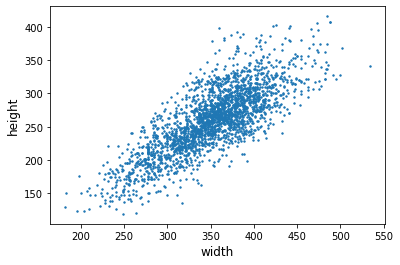

In [ ]:
x = [i[0] for i in sizes]
y = [i[1] for i in sizes]
plt.scatter(x, y, s=2)
plt.xlabel('width', fontsize='large')
plt.ylabel('height', fontsize = 'large')
plt.show()

Check if the dataset is balanced, so if there are more or less the same number of images with covid and without


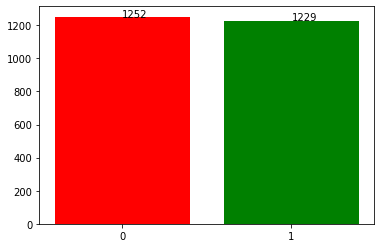

In [ ]:
covid = len(os.listdir('/content/sarscov2-ctscan-dataset/COVID'))
no_covid = len(os.listdir('/content/sarscov2-ctscan-dataset/non-COVID'))
plt.bar([0,1], [covid, no_covid], color=['red', 'green'])
plt.text(0,covid+0.1,covid,fontsize=10,color='black')
plt.text(1,no_covid+0.1,no_covid,fontsize=10,color='black')
plt.xticks(np.arange(0, 2, 1))
plt.show()

In order to create a system that is able to answer the first query with the most precision and less time consuming (identifying the ct scan images with covid) we evaluated different approaches. First approach is use supervised training with binary classification.

## Classification - supervised learning

In [ ]:
# setup global parameter
TRAINING_DIR = '/content/splitted_img/train'
VALIDATION_DIR = '/content/splitted_img/val'
TEST_DIR = '/content/splitted_img/test'
IMG_SIZE = 256
BATCH_SIZE = 64
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 10

In [ ]:
# folder splitting
splitfolders.ratio("./sarscov2-ctscan-dataset", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:01, 2122.87 files/s]


Create train, validation and test set and divide images in a random way between this three sets. It's also applyed image resizing and rescaling. Labels are inferred based on folders in which we have the images

In [ ]:
%%capture
# creating train, validation and test sets applying image resizing
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale', 
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)


Pixel normalization for all images, the train set is also shuffled.

In [ ]:
# pixel normalization 
def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
train_ds = normalize_data(train_dataset, True)
val_ds = normalize_data(val_dataset, False)
test_ds = normalize_data(test_dataset)

### Classification using a Convolutional Neural Network (CNN)

Since we're dealing with an image binary classification problem, we decided to choose a Convolutional Neural Network.
A Convolutional Neural Network (CNN) is an artificial neural network suited for images, with a sequence of layers, and every layer transforms one volume of activations to another through a differentiable function. We used three main types of layers to build our neural network: Convolutional Layer, Pooling Layer and Fully-Connected Layer.

In [ ]:
def cnn_class():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

Structure of the Convolutional Neural Network

In [ ]:
cnn = cnn_class()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
#@markdown Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

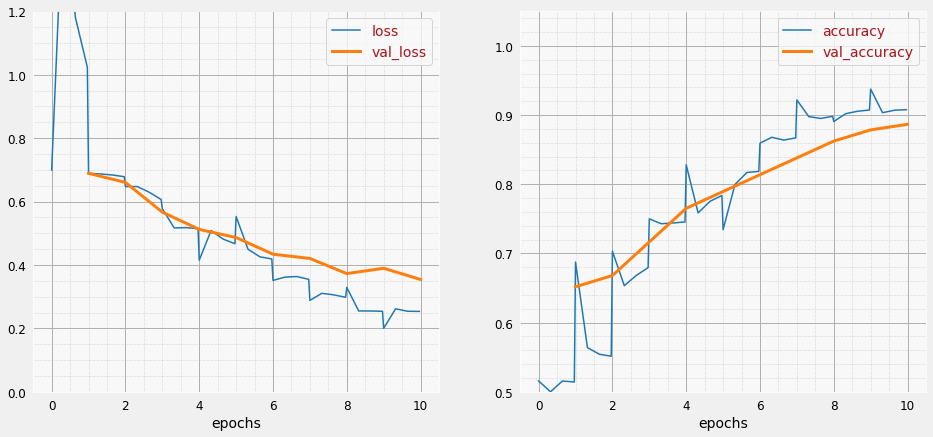

31/31 [==============================] - 2s 75ms/step - loss: 0.2535 - accuracy: 0.9078 - val_loss: 0.3542 - val_accuracy: 0.8866


In [ ]:
# setup model training
EPOCHS = 10

start_cnn_time = time.time()
plot_training = PlotTraining(sample_rate=10, zoom=1)

history = cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training]
)

end_cnn_time = time.time() - start_cnn_time

Results of the supervised training with the CNN

In [ ]:
print("Results of classification with a CNN\n")
print("Time used for training: "+   str(datetime.timedelta(seconds = end_cnn_time)))
print("Accuracy: "+str(round(history.history['val_accuracy'][-1],2)))
print("Loss: "+str(round(history.history['val_loss'][-1],2)))

Results of classification with a CNN

Time used for training: 0:00:52.320593
Accuracy: 0.89
Loss: 0.35


With this CNN we reach good results, we can reach an accuracy of 89% with less than a minute of training time.

## Clustering - unsupervised learning

The idea is to use a cluster algorithm to divide in two clusters: images with covid sympthoms and images without covid sympthoms. In this case we use only images without label.

In [ ]:
# moving all images into a single folder since we don't need labels for clustering
source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset-clustering'

os.mkdir(target_dir)

file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

### Clustering with PCA (KMeans)

PCA allows us to extract features and at the same time reduce the dimensions of our dataset to any number less than current number of features, always preserving the maximum amount of information. PCA also compress the data and reduce the computational time.

With PCA is used kmeans clustering algorithm fixing 2 as number of clusters

In [ ]:
path_images = '/content/sarscov2-ctscan-dataset-clustering'

start_pca_k = time.time()

cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,  
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)
X = X['pathnames']

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='kmeans',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=3,
                           cluster_space='high')
results.keys()

end_pca_k = time.time() - start_pca_k

100%|██████████| 2481/2481 [00:14<00:00, 176.25it/s]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.

[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


In [ ]:
# checking results
def check_results(clusters):
  if(len(clusters)!=2):
    print("num clusters detected not correct.")
    print("num clusters detected: "+str(len(clusters)))

  else:
    for i,cluster in enumerate(clusters.values()):
      count_non=0
      count = 0
      for elem in cluster: 
        if 'Non' in elem: 
          count_non += 1
        else:
          count +=1

      print("\n% img without covid in cluster " + str(i) + " : " + str(round(count_non/len(cluster)*100,2)))
      print("% img with covid in cluster " + str(i) + " : " + str(round(count/len(cluster)*100,2)))


  return count_non, count

In [ ]:
groups_pca = {}
for file, cluster in zip(results['pathnames'],results['labels']):
    if cluster not in groups_pca.keys():
        groups_pca[cluster] = []
        groups_pca[cluster].append(file)
    else:
        groups_pca[cluster].append(file)

In [ ]:
for i,value in enumerate(results['pathnames']):
  results['pathnames'][i] = os.path.basename(results['pathnames'][i])
results['pathnames']

array(['Non-Covid (628).png', 'Non-Covid (778).png', 'Covid (732).png',
       ..., 'Covid (224).png', 'Non-Covid (661).png',
       'Non-Covid (108).png'], dtype='<U64')

In [ ]:
# creating dataframe to show the results
df_pca = pd.DataFrame(results['pathnames'], columns=['nome'])
df_pca["cluster pca"] = results['labels']
df_pca.replace(-1, 
           1, 
           inplace=True)

Results of clustering using PCA as a method for feature extraction and kmeans as a clustering algorithm

In [ ]:
print("Results of clustering with PCA & Kmeans \n")
print("Time used for training: "+   str(datetime.timedelta(seconds = end_pca_k)))

count_non, count = check_results(groups_pca)

Results of clustering with PCA & Kmeans 

Time used for training: 0:03:04.251875

% img without covid in cluster 0 : 58.31
% img with covid in cluster 0 : 41.69

% img without covid in cluster 1 : 31.57
% img with covid in cluster 1 : 68.43


In [ ]:
non_covid = 0
if (count < count_non):
  non_covid = 1

In [ ]:
df_pca["True Label"] = np.zeros(len(df_pca), int)
for i in df_pca.index:
  if 'Non' in df_pca.nome.loc[i]:
    df_pca["True Label"].loc[i] = non_covid
  else:
    df_pca["True Label"].loc[i] = 1 - non_covid
df_pca

,nome,cluster pca,True Label
0,Non-Covid (628).png,1,0
1,Non-Covid (778).png,1,0
2,Covid (732).png,1,1
3,Non-Covid (36).png,1,0
4,Covid (823).png,1,1
...,...,...,...
2476,Non-Covid (792).png,1,0
2477,Non-Covid (769).png,0,0
2478,Covid (224).png,1,1
2479,Non-Covid (661).png,1,0


In [ ]:
len(df_pca[(df_pca['True Label'] == 1) & (df_pca['cluster pca'] == 1)])

695

Confusion matrix that visualize the results of the clustering algorithm applying PCA and Kmeans. We can see that the system is able to correctly classifying a great number of true negative; on the other hand it has also a lot of false negative. This is due to the fact that the feature extraction algorithm can't extract the correct pattern in order to recognize if an image represents a person tested positive for Covid. 

Text(0.5, 86.87999999999997, 'Predicted')

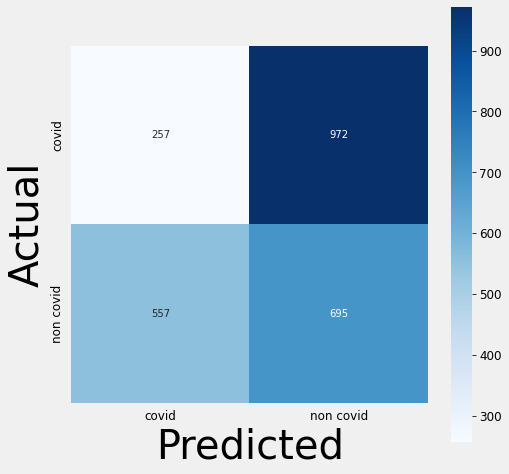

In [ ]:
cm_pca = confusion_matrix(df_pca['True Label'], df_pca['cluster pca'])
disease_types = ['covid', 'non covid']
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm_pca, cmap=plt.cm.Blues, annot=True, square=True, fmt='g', xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

### Clustering using VGG for feature extraction and KMeans

Antoher approach is to use a Convolutional Neural Network as a feature extraction method, in particular using VGG16, a CNN suited for image classification. This network was used without the last layer, using as new final layer a fully-connected layer with 4,096 output nodes. This vector of 4,096 numeric values is the feature vector that we will use to cluster the images. Kmeans is used afterwards as clustering algorithm.

In [ ]:
path_images = '/content/sarscov2-ctscan-dataset-clustering'

# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
img_filenames = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the img_filenames list
            img_filenames.append(file.name)

Definition of the feature extraction method

In [ ]:
# model definition

def extract_features_vgg(direc):
    features = []
    images_name = []
    # load the image as a 224x224 array
    model = VGG16()
    # exclude classification layer
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    for i in direc:
      img = tf.keras.utils.load_img(i, target_size=(224,224))
      x = tf.keras.utils.img_to_array(img)
      reshaped_img = x.reshape(1,224,224,3) 
      imgx = preprocess_input(reshaped_img)
      feat = model.predict(imgx, use_multiprocessing=True)
      features.append(feat)
      images_name.append(i)
    return features, images_name

We convert the output of the convolutional part of the CNN into a 1D feature vector, to be used by the ANN part of it. This operation is called flattening. It gets the output of the convolutional layers, flattens all its structure to create a single long feature vector to be used by the dense layer. Then it's applied the Kmeans algorithm for clustering

In [ ]:
%%capture
start_time_vggkmeans = time.time()
img_feat, img_name = extract_features_vgg(img_filenames)

# flatten images in order to apply the clustering algorithm
flattened_img = []
for i in img_feat:
  flattened_img.append(i.flatten())

# cluster
k = 2

clusters_vgg = KMeans(k, random_state = 13)
clusters_vgg.fit(flattened_img)
final_time_vggmeans = time.time() - start_time_vggkmeans
#print("--- %s seconds ---" % (time.time() - start_time_vggkmeans))

Visualization of a given filter within the CNN

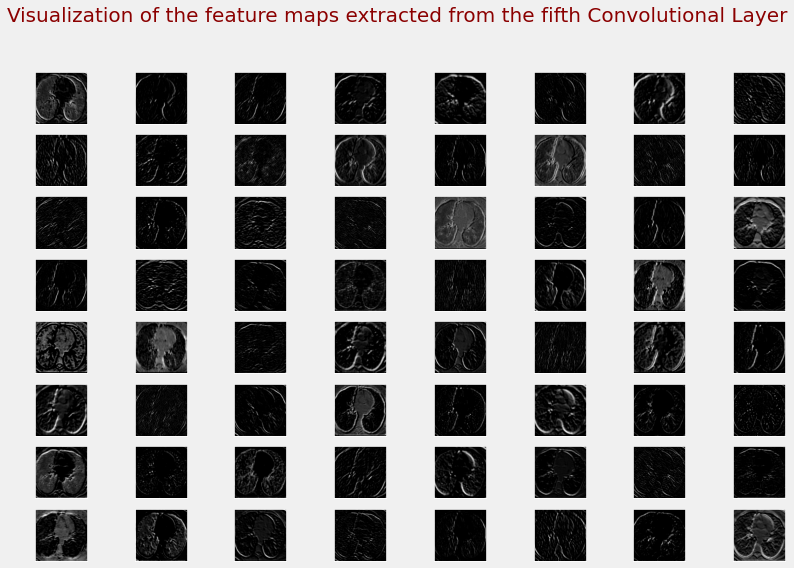

In [ ]:
# random image
img_to_print = img_filenames[45]

# recreating the model to select a fixed hidden layer
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[5].output)
img = tf.keras.utils.load_img(img_to_print, target_size=(224,224))
x = tf.keras.utils.img_to_array(img)
reshaped_img = x.reshape(1,224,224,3) 
imgx = preprocess_input(reshaped_img)
feat = model.predict(imgx, use_multiprocessing=True, verbose = 0)
feature_maps = feat
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1

fig, axs = plt.subplots(square, square)
fig.suptitle('Visualization of the feature maps extracted from the fifth Convolutional Layer', fontsize= 20, color='darkred')
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
plt.show()

In [ ]:
# creating dataframe to show the results
df_vgg = pd.DataFrame(img_name, columns=['nome'])
df_vgg["cluster vgg"] = clusters_vgg.labels_
df_vgg.head(10)

,nome,cluster vgg
0,Non-Covid (628).png,0
1,Non-Covid (778).png,1
2,Covid (732).png,1
3,Non-Covid (36).png,0
4,Covid (823).png,1
5,Covid (63).png,0
6,Covid (765).png,0
7,Covid (1164).png,0
8,Covid (9).png,0
9,Non-Covid (854).png,0


In [ ]:
# checking results
count_nocovid_zero, count_nocovid_uno, count_covid_zero, count_covid_uno= 0,0,0,0
len_zero, len_uno = 0,0

for index, row in df_vgg.iterrows():
    if 'Non' in row['nome'] :
      if row['cluster vgg'] == 0:
        count_nocovid_zero += 1
        len_zero +=1
      if row['cluster vgg'] == 1:
        count_nocovid_uno += 1
        len_uno +=1
    else:
      if row['cluster vgg'] == 0:
        count_covid_zero += 1
        len_zero +=1
      if row['cluster vgg'] == 1:
        count_covid_uno += 1
        len_uno +=1

View the results and the time consuming of clustering with VGG and KMeans 

In [ ]:
print("Results of clustering with VGG & Kmeans \n")
print("Time used for training: "+   str(datetime.timedelta(seconds = final_time_vggmeans)))

print("\n% images without covid in cluster 0: "+str(round(count_nocovid_zero/len_zero*100,2)))
print("% images with covid in cluster 0: "+str(round(count_covid_zero/len_zero*100,2)))

print("\n% images without covid in cluster 1: "+str(round(count_nocovid_uno/len_uno*100,2)))
print("% images with covid in cluster 1: "+str(round(count_covid_uno/len_uno*100,2)))

Results of clustering with VGG & Kmeans 

Time used for training: 0:02:38.314332

% images without covid in cluster 0: 45.79
% images with covid in cluster 0: 54.21

% images without covid in cluster 1: 54.59
% images with covid in cluster 1: 45.41


In [ ]:
non_covid = 0
if (count_covid_uno < count_nocovid_uno):
  non_covid = 1
df_vgg["True Label"] = np.zeros(len(df_vgg), int)
for i in df_vgg.index:
  if 'Non' in df_vgg.nome.loc[i]:
    df_vgg["True Label"].loc[i] = non_covid
  else:
    df_vgg["True Label"].loc[i] = 1 - non_covid

Dataframe to compare the true label and the label predicted. The label predicted is associated to the cluster that contains the majority of images of that type.

In [ ]:
df_vgg.head(10)

,nome,cluster vgg,True Label
0,Non-Covid (628).png,0,1
1,Non-Covid (778).png,1,1
2,Covid (732).png,1,0
3,Non-Covid (36).png,0,1
4,Covid (823).png,1,0
5,Covid (63).png,0,0
6,Covid (765).png,0,0
7,Covid (1164).png,0,0
8,Covid (9).png,0,0
9,Non-Covid (854).png,0,1


Confusion matrix that visualize the results of the clustering using VGG16 and kmeans. We can see that the system is able to classify in the correct way a great number of true negative but it has also a lot of false negative; it's not better than the PCA method.

Text(0.5, 86.87999999999997, 'Predicted')

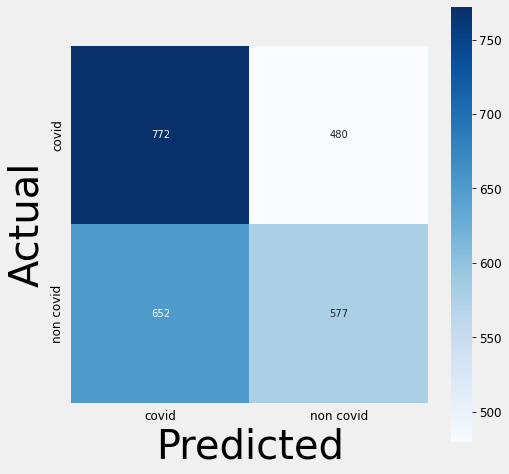

In [ ]:
cm = confusion_matrix(df_vgg['True Label'], df_vgg['cluster vgg'])
disease_types = ['covid', 'non covid']
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, fmt='g', xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

## Image similarity
Calculating image similarity using different similarity metrics.

In [ ]:
# creating dataframe using img feature calculated beforehand
df_images = pd.DataFrame(flattened_img, index=img_name)
df_images.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Non-Covid (628).png,0.0,0.0,0.0,5.381503,0.0,0.0,0.627413,0.0,0.0,0.000000,...,0.0,0.0,0.835844,0.000000,0.0,0.0,0.0,0.097637,0.0,1.095752
Non-Covid (778).png,0.0,0.0,0.0,4.343820,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,1.314073,1.839664,0.0,0.0,0.0,0.000000,0.0,0.513134
Covid (732).png,0.0,0.0,0.0,6.332058,0.0,0.0,0.000000,0.0,0.0,0.143826,...,0.0,0.0,0.000000,1.228277,0.0,0.0,0.0,0.000000,0.0,0.976582
Non-Covid (36).png,0.0,0.0,0.0,6.998568,0.0,0.0,2.809602,0.0,0.0,0.000000,...,0.0,0.0,0.573980,0.538679,0.0,0.0,0.0,0.000000,0.0,1.105775
Covid (823).png,0.0,0.0,0.0,4.979441,0.0,0.0,0.000000,0.0,0.0,0.015460,...,0.0,0.0,0.000000,2.526708,0.0,0.0,0.0,0.000000,0.0,0.558376


### Euclidean distance

\begin{equation}
    d(a,b)=\sqrt{(x_1 - y_1)^2+(x_2 - y_2)^2 + ... + (x_n - y_n)^2}
\end{equation}


Calculate the distance matrix 

In [ ]:
# euclidean (default parameter distance_matrix p = 2)
start_euclidean = time.time()
euclidean = pd.DataFrame(distance_matrix(df_images.values, df_images.values), index=df_images.index, columns=df_images.index)
final_euclidean = time.time() - start_euclidean

Print the 10 closest images given an image

In [ ]:
# printing the closest images to a given image (test)
euclidean['Covid (11).png'].nsmallest(10)

Covid (11).png      0.000000
Covid (9).png      39.165705
Covid (10).png     43.618239
Covid (7).png      45.848620
Covid (8).png      53.503711
Covid (986).png    53.796337
Covid (439).png    54.526708
Covid (381).png    54.982352
Covid (985).png    55.042412
Covid (525).png    55.890201
Name: Covid (11).png, dtype: float64

### Cosine distance

\begin{equation}
    d(a,b)=  \frac{A \cdot B}{||A|| \cdot ||B||}
\end{equation}

In [ ]:
start_cosine_time = time.time()
result=np.zeros((len(flattened_img), len(flattened_img)))
for i in range(len(flattened_img)):
  for j in range(len(flattened_img)):
    result[i][j] = distance.cosine(flattened_img[i], flattened_img[j])

cosine_df = pd.DataFrame(result, columns = img_name, index = img_name)
final_cosine = time.time()-start_cosine_time

Print the 10 closest images given an image

In [ ]:
# printing the closest images to a given image (test)
cosine_df['Covid (11).png'].nsmallest(10)

Covid (11).png     0.000000
Covid (9).png      0.122117
Covid (10).png     0.142294
Covid (7).png      0.164561
Covid (8).png      0.204181
Covid (5).png      0.221175
Covid (511).png    0.222710
Covid (475).png    0.228059
Covid (986).png    0.229157
Covid (985).png    0.232487
Name: Covid (11).png, dtype: float64

## Summary

We've compared the different approaches and we've summarised the different execution times in the next table.

In [ ]:
rows = ['Classification with CNN', 'Clustering with PCA - KMeans', 'Clustering with VGG - KMeans', 'Image similarity - Euclidean', 'Image similarity - Cosine']
column = ['Computational time']
computational_times = [str(datetime.timedelta(seconds = end_cnn_time)), str(datetime.timedelta(seconds = end_pca_k)),
                           str(datetime.timedelta(seconds = final_time_vggmeans)), str(datetime.timedelta(seconds = final_euclidean)), str(datetime.timedelta(seconds = final_cosine))]
df_summary = pd.DataFrame(computational_times, columns = column, index = rows)
df_summary

,Computational time
Classification with CNN,0:00:52.320593
Clustering with PCA - KMeans,0:03:04.251875
Clustering with VGG - KMeans,0:02:38.314332
Image similarity - Euclidean,0:02:26.291322
Image similarity - Cosine,0:06:44.952603


Unsupervised training needs more training time and produce results with less precision; it makes sense since labels aren't used in this method. 

In [ ]:
def has_covid(stringa):
  if 'Non' in stringa:
    return 0
  return 1


def precision_score(image, retrieved):
  result = 0
  for i in retrieved.keys():
    if has_covid(i) == has_covid(image):
      result += 1
  return round(result/len(retrieved),2)

def funct_precision(x, df_metric, img_names):
  avg_precision = {}
  for i in img_names:
    res = df_metric[i].nsmallest(x+1)[1:]
    avg_precision[i] = precision_score(i, res)
  return sum(avg_precision.values())/len(avg_precision)

def recall_score(image, retrieved, tot_pos, tot_neg):
  result = 0
  for i in retrieved.keys():
    if has_covid(i) == has_covid(image):
      result += 1
  return result/tot_pos if has_covid(image) else result/tot_neg

def count_(img_names):
  count_pos, count_neg = 0,0
  for i in img_names:
    if has_covid(i):
      count_pos += 1
    else:
      count_neg += 1
  return count_pos, count_neg

def funct_recall(x, df_metric, img_names):
  avg_recall = {}
  for i in img_names:
    res = df_metric[i].nsmallest(x+1)[1:]
    tot_pos, tot_neg = count_(img_name)
    avg_recall[i] = recall_score(i, res, tot_pos, tot_neg)
  return sum(avg_recall.values())/len(avg_recall)


The 33 images more similar are
Covid (18).png : 0.085
Covid (16).png : 0.094
Covid (15).png : 0.122
Covid (1183).png : 0.161
Covid (12).png : 0.166
Covid (1086).png : 0.167
Covid (1145).png : 0.168
Non-Covid (149).png : 0.17
Covid (341).png : 0.171
Covid (1144).png : 0.174
Covid (266).png : 0.175
Covid (19).png : 0.176
Covid (1083).png : 0.176
Covid (1182).png : 0.177
Covid (264).png : 0.181
Covid (1178).png : 0.182
Covid (342).png : 0.183
Covid (1179).png : 0.187
Non-Covid (1217).png : 0.188
Non-Covid (411).png : 0.188
Non-Covid (150).png : 0.189
Non-Covid (418).png : 0.192
Covid (663).png : 0.193
Covid (1146).png : 0.193
Covid (1141).png : 0.193
Covid (1090).png : 0.195
Covid (23).png : 0.195
Covid (343).png : 0.196
Covid (1174).png : 0.197
Covid (13).png : 0.197
Covid (1227).png : 0.198
Covid (1136).png : 0.198
Non-Covid (1052).png : 0.199

With an average precision of: 0.82


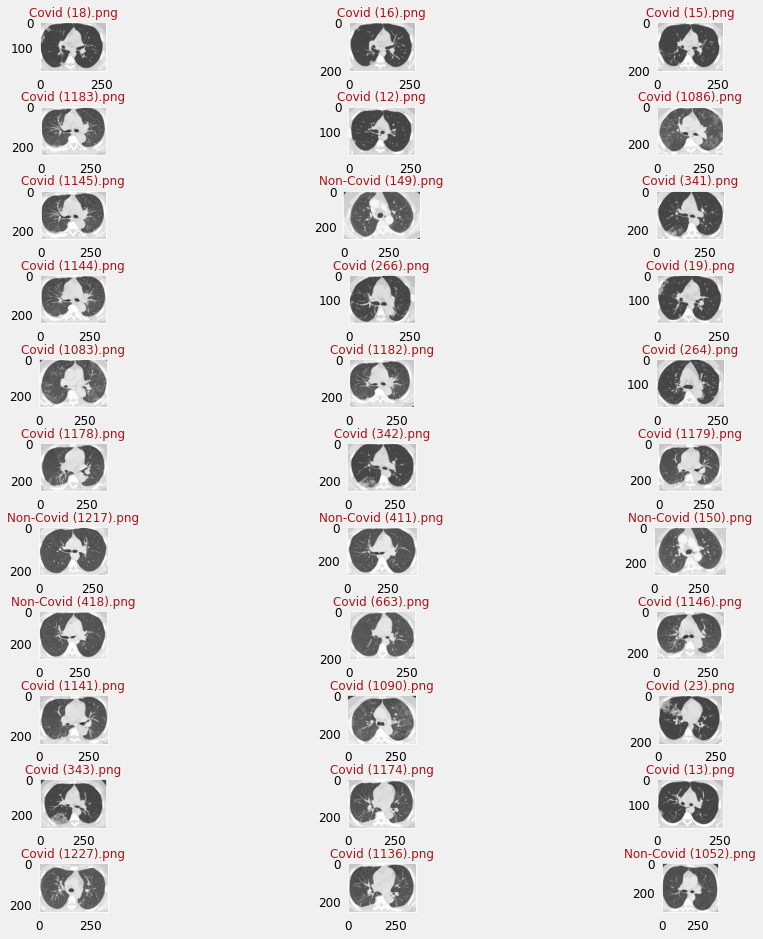

In [ ]:
#@title Queries for the most similar images  { run: "auto" }
#inizialize 

#@markdown Extract the first *n* images more similar to the image choosen and following the choosen metrica { run: "auto" }
num_images = 12 #@param {type:"integer"}
num_images +=1
metric = "cosine" #@param ["euclidean", "cosine"]
file_name = "Covid (17).png" #@param {type:"string"}

if len(file_name.strip())!=0:
  if metric == "euclidean":
    res = euclidean[file_name].nsmallest(num_images)[1:]
  else:
    res = cosine_df[file_name].nsmallest(num_images)[1:]

res = dict(res)
print(f"The {num_images-1} images more similar are")
for key,value in res.items():
	print(key, ':', round(value,3))
 
print(f"\nWith an average precision of: {precision_score(file_name, res)}")

# printing images

NROWS = int(len(res)/3) if len(res)%3 == 0 else int((len(res))/3)+1
#print(NROWS)
fig, axs = plt.subplots(nrows=NROWS, ncols=3, figsize=(13, 13))
fig.tight_layout()
# flatten the axis into a 1-d array to make it easier to access each axes
axs = axs.flatten()
for i, result_keys in enumerate(res.keys()):
  content_images = '/content/sarscov2-ctscan-dataset-clustering/'+result_keys
  pic = plt.imread(content_images)
  axs[i].imshow(pic)
  axs[i].set(title=result_keys)


In [ ]:
X = np.array(range(1, 2481, 10))
Y_precision_euclidean = np.array([funct_precision(i, euclidean, img_name) for i in X])
Y_precision_cosine = np.array([funct_precision(i, cosine_df, img_name) for i in X])

Precision plot averaged over all images with the euclidean distance.
The precision is calculate as an average precision over all the images.


In [ ]:
X_scatter = np.array(range(10, 60, 10))
Y_scatter_euclidean = np.array([funct_precision(i, euclidean, img_name) for i in X_scatter])
Y_scatter_cosine = np.array([funct_precision(i, cosine_df, img_name) for i in X_scatter])
Y_scatter_euclidean

array([0.8789601 , 0.81680774, 0.77910117, 0.75336558, 0.7325917 ])

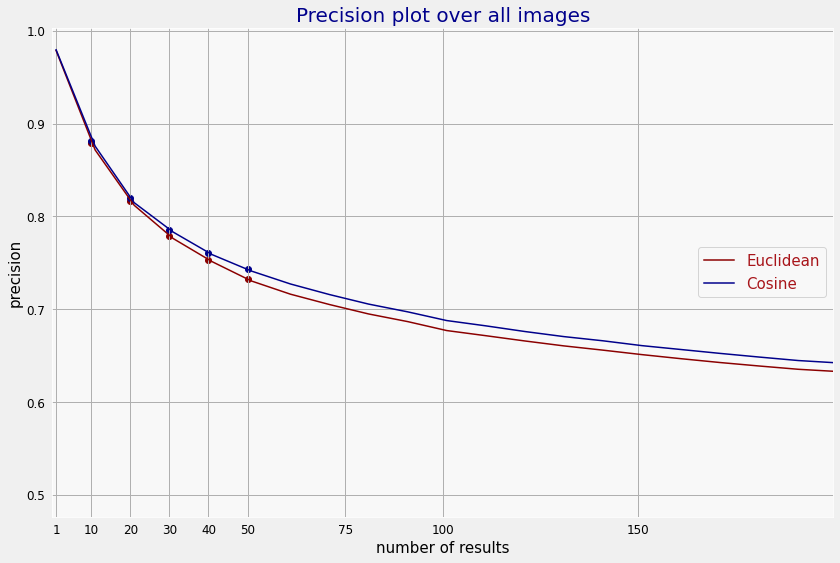

In [ ]:
plt.plot(X, Y_precision_euclidean, color='darkred', label = 'Euclidean')
plt.plot(X, Y_precision_cosine,color='darkblue', label = 'Cosine')
plt.scatter(X_scatter, Y_scatter_euclidean, color='darkred')
plt.scatter(X_scatter, Y_scatter_cosine, color='darkblue')
plt.legend(loc="center right", fontsize=15)
plt.xlabel("number of results",fontsize=15)
plt.ylabel("precision",fontsize=15)
plt.xticks([1,10,20,30,40,50,75,100,150])
plt.xlim(0,200)
plt.grid()

plt.title('Precision plot over all images',fontdict={'fontsize':20,'color':'darkblue'})
for i in range(1,6):
  index = i
  #plt.annotate(str(round(Y_precision_euclidean[index],2)), xy=(X[index], Y_precision_euclidean[index]), color='red')
  #plt.annotate(str(round(Y_precision_cosine[index],2)), xy=(X[index], Y_precision_cosine[index]))
plt.show()

In [ ]:
Y_recall_euclidean = np.array([funct_recall(i, euclidean, img_name) for i in X])
Y_recall_cosine = np.array([funct_recall(i, cosine_df, img_name) for i in X])

Precision-recall curve averaged over all images.

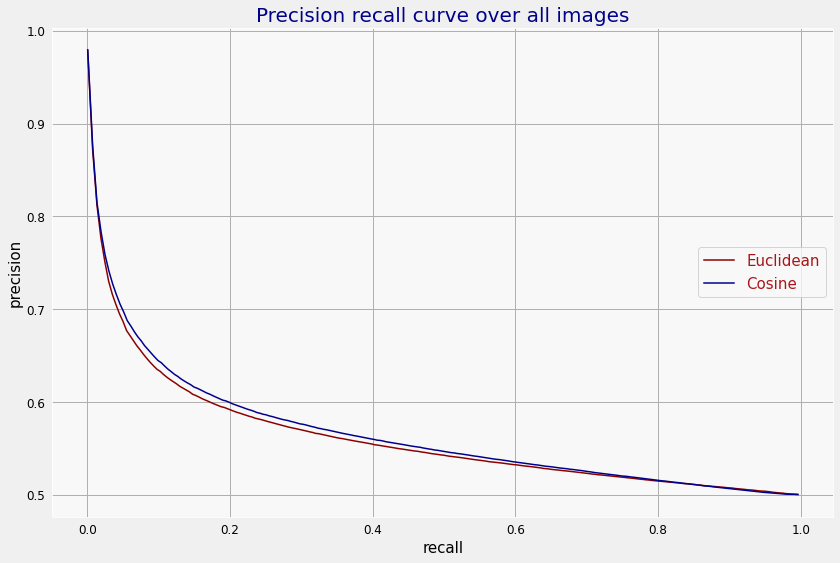

In [ ]:
plt.plot(Y_recall_euclidean, Y_precision_euclidean, label='Euclidean', color='darkred')
plt.plot(Y_recall_cosine, Y_precision_cosine, label='Cosine', color='darkblue')
plt.xlabel("recall",fontsize=15)
plt.ylabel("precision",fontsize=15)
plt.legend(loc='center right', fontsize=15)
plt.grid()
plt.title('Precision recall curve over all images',fontdict={'fontsize':20,'color':'darkblue'})
plt.show()

The cluster relative to the image choosen is the cluster number 1. The first 12 images of this cluster are: 

                   nome  cluster pca  True Label
0   Non-Covid (628).png            1           0
1   Non-Covid (778).png            1           0
2       Covid (732).png            1           1
3    Non-Covid (36).png            1           0
4       Covid (823).png            1           1
5        Covid (63).png            1           1
11      Covid (380).png            1           1
13    Non-Covid (2).png            1           0
14  Non-Covid (670).png            1           0
16  Non-Covid (748).png            1           0
17       Covid (78).png            1           1
19  Non-Covid (202).png            1           0


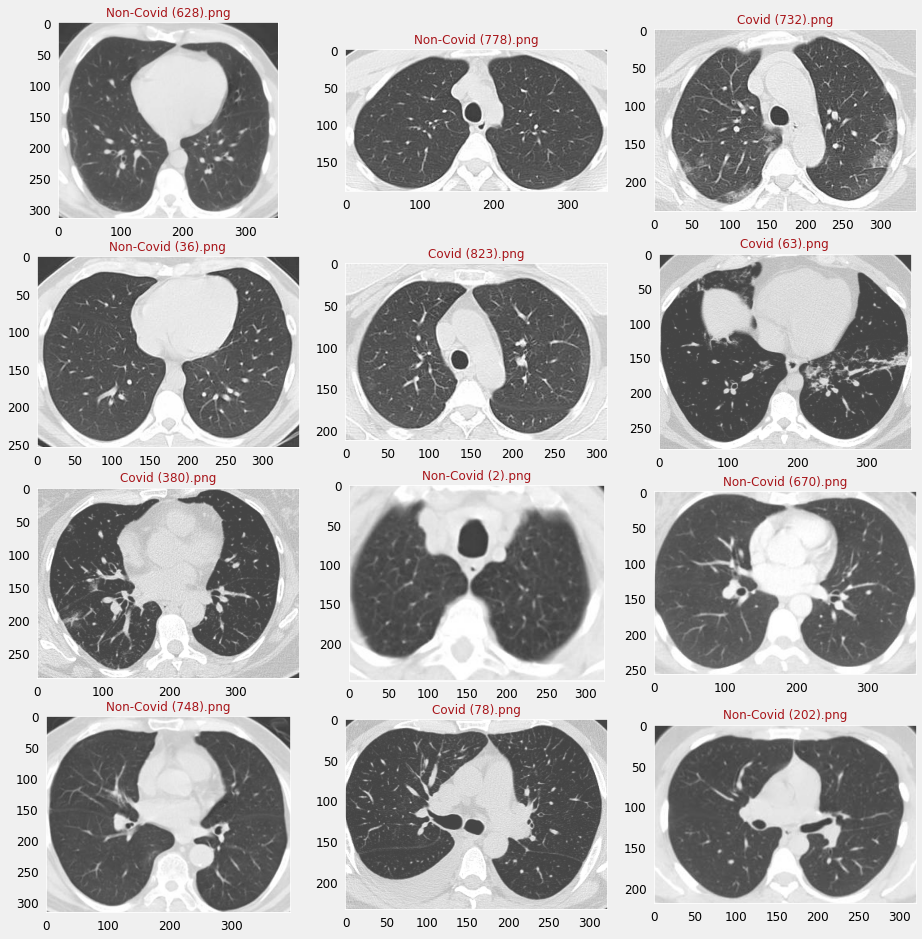

In [ ]:
#@title Queries for the most similar images considering clustering { run: "auto" }

#@markdown Extract first *n* images from the cluster of the image choosen

num_images = 12 #@param {type:"integer"}
file_name = "Non-Covid (18).png" #@param {type:"string"}
method = "PCA" #@param ["PCA", "VGG"]

if method == "VGG":
  cluster = df_vgg[df_vgg['nome'] == file_name].iloc[0]['cluster vgg']
  print(f"The cluster relative to the image choosen is the cluster number {cluster}. The first {num_images} images of this cluster are: \n")
  print(df_vgg.loc[df_vgg['cluster vgg'] == cluster][:num_images])

else:
  cluster = df_pca[df_pca['nome'] == file_name].iloc[0]['cluster pca']
  print(f"The cluster relative to the image choosen is the cluster number {cluster}. The first {num_images} images of this cluster are: \n")
  print(df_pca.loc[df_pca['cluster pca'] == cluster][:num_images])



NROWS = int(num_images/3) if num_images%3 == 0 else int(num_images/3)+1
#print(NROWS)
fig, axs = plt.subplots(nrows=NROWS, ncols=3, figsize=(13, 13))
fig.tight_layout()
# flatten the axis into a 1-d array to make it easier to access each axes
axs = axs.flatten()
for i, single_img in enumerate(df_pca.loc[df_pca['cluster pca'] == cluster][:num_images]['nome']):
  content_images = '/content/sarscov2-ctscan-dataset-clustering/'+single_img
  pic = plt.imread(content_images)
  axs[i].imshow(pic)
  axs[i].set(title=single_img)
